In [1]:
from keras.models import model_from_json
import cv2
import numpy as np
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [3]:
with open("model.json", "r") as jfile:
    clf = model_from_json(jfile.read())
    
clf.load_weights("model.h5")

test_img1 = cv2.imread("training_images/vehicles/GTI_Far/image0000.png")[:,:,::-1]
test_img1 = cv2.resize(test_img1, (32, 32))
test_img1 = np.expand_dims(test_img1, axis=0)

pred1 = clf.predict(test_img1)

print("Positive example: {}".format(np.argmax(pred1)))

test_img2 = cv2.imread("training_images/non-vehicles/Extras/extra1.png")[:,:,::-1]
test_img2 = cv2.resize(test_img2, (32, 32))
test_img2 = np.expand_dims(test_img2, axis=0)

pred2 = clf.predict(test_img2)
print("Negative example: {}".format(np.argmax(pred2)))

Positive example: 1
Negative example: 0


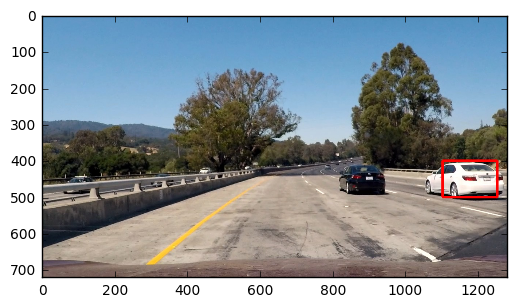

In [10]:
image = cv2.imread("test_images/test1.jpg")[:,:,::-1].copy()

image = cv2.rectangle(image, (1100, 400), (1250, 500), (255, 0, 0), 6)

plt.imshow(image)

In [11]:
def test_window(image, top_left=(0, 0), bottom_right=(100, 100)):
    
    window_img = image[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0], :]
    
    resized_img = cv2.resize(window_img, (32, 32))
    
    exp_res = np.expand_dims(resized_img, axis=0)
    
    pred = clf.predict(exp_res)
    
    return np.argmax(pred)
    
pred = test_window(test_img, top_left=(1100, 400), bottom_right=(1250, 500))

print(pred)

1


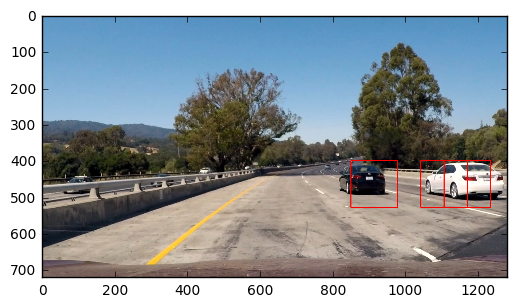

In [12]:
def sliding_windows(image, start=[None, None], stop=[None, None], window=[128, 128], stride=[128, 128]):
    if start[0] == None:
        start[0] = 0
    if start[1] == None:
        start[1] = 0
    if stop[0] == None:
        stop[0] = image.shape[1]
    if stop[1] == None:
        stop[1] = image.shape[0]
    
    top_left = [start[0], start[1]]
    bottom_right = [top_left[0] + window[0], top_left[1] + window[1]]
    
    while bottom_right[1] <= stop[1]:
        top_left[0] = start[0]
        bottom_right[0] = top_left[0] + window[0]
        
        while bottom_right[0] <= stop[0]:
            if test_window(image, top_left=top_left, bottom_right=bottom_right) == 1:
                cv2.rectangle(image, tuple(top_left), tuple(bottom_right), (255, 0, 0), 2)

            top_left[0] += stride[0]
            bottom_right[0] += stride[0]
            
        top_left[1] += stride[1]
        bottom_right[1] += stride[1]
        
    return image

test_img = cv2.imread("test_images/test1.jpg")[:,:,::-1].copy()

box_image = sliding_windows(test_img, start=[336, 336], stop=[None, None], window=[128, 128], stride=[64, 64])

plt.imshow(box_image)

In [18]:
def pipeline(image):
    
    box_image = sliding_windows(image, start=[336, 336], stop=[None, None], window=[64, 64], stride=[32, 32])
    
    return box_image

In [19]:
output_video = 'output_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4


100%|█████████▉| 1260/1261 [04:36<00:00,  5.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 

CPU times: user 8min 18s, sys: 1min 34s, total: 9min 53s
Wall time: 4min 37s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))